#Identificando o problema
Em uma troca de bate-papo, uma amiga que é professa me contou que estava sobrecarregada para corrigir às atividades de seus alunos. Perguntei a ela o que tava acontecendo. Gaby me contou que estava ensinado várias turmas grandes de forma EAD devido ao atual senário pandêmico, isso acarretou que ela teve que buscar novos conhecimentos como a utilização de plataforma de EAD, gravação e edição de vídeos e outros processos de digitalização. O que estava deixando ela preocupado é que ela tinha mais de 500 atividades para corrigir e tinha uma prazo para entregar e estava insegura de não corrigir a tempo. Decide perguntar como era as atividades
e elas me explicou que tava ensinado a caligrafia dos números de 0 à 9. Para isso, estava utilizando uma tabela de 10 linhas e 8 colunas. Na primeira coluna estavam os números e as demais estavam vazias para serem preenchidas pelos alunos. Na figura abaixo é possível visualizar a tabela.

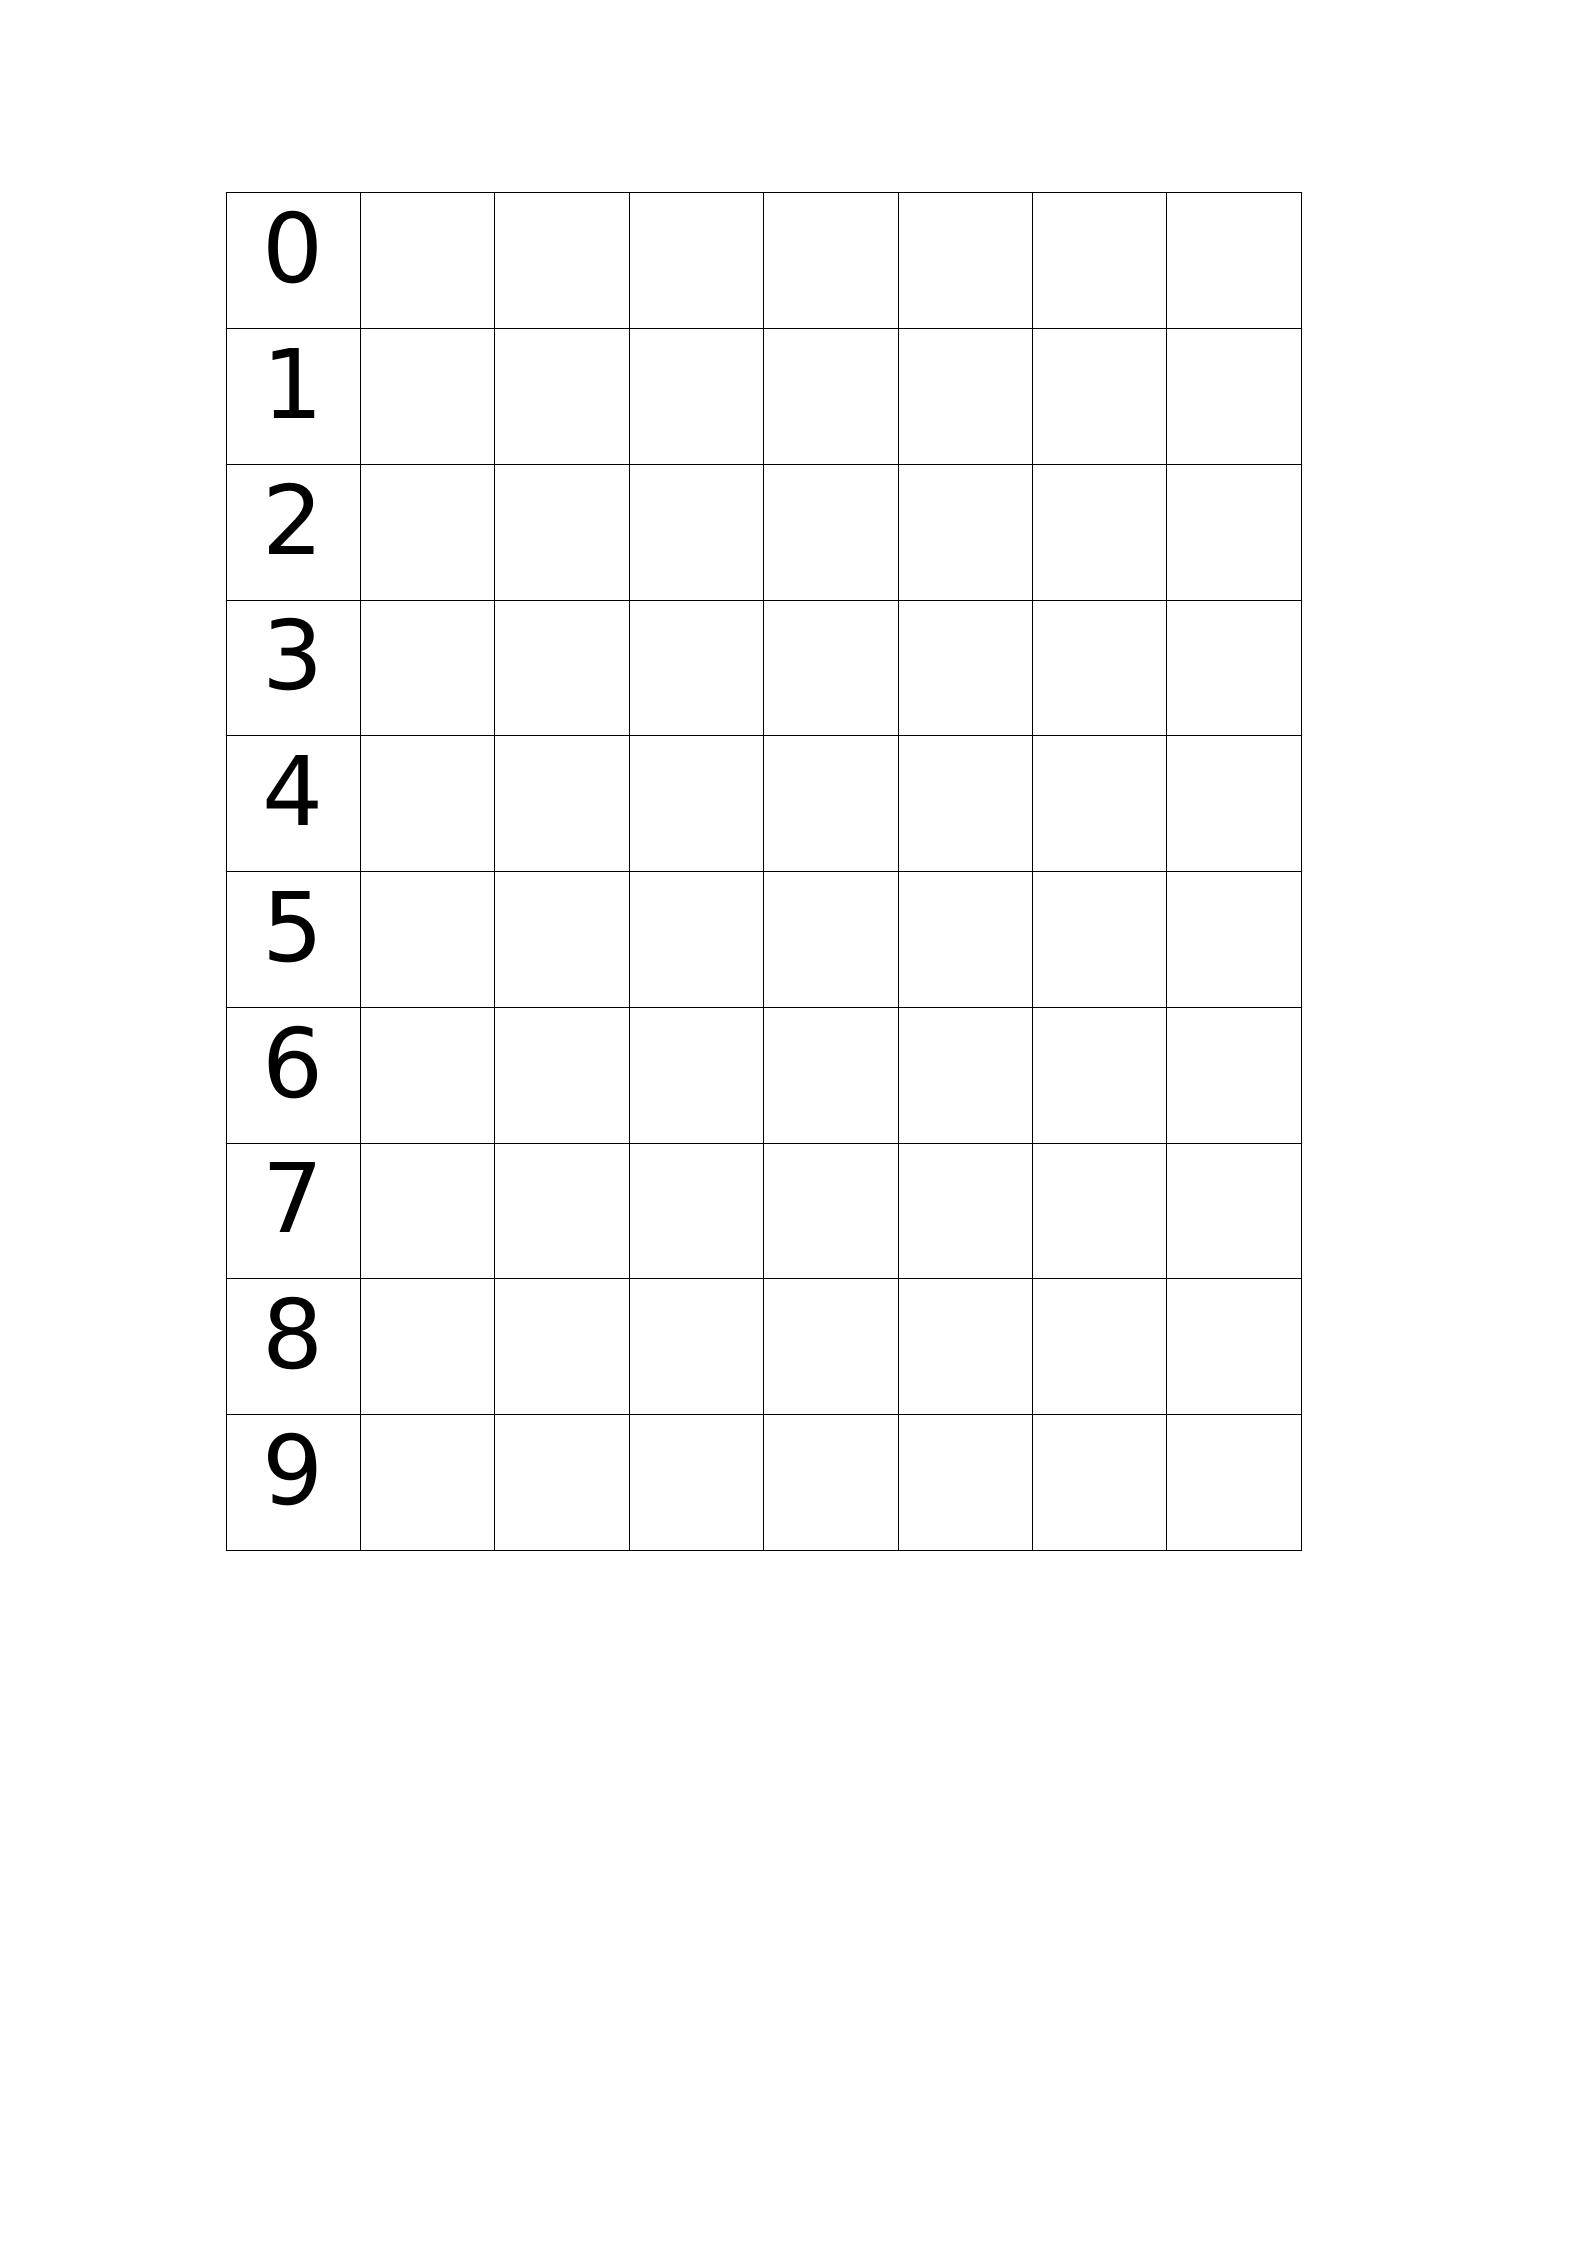

# Idealizando
Falei para ela que estava cursando a disciplina TÓPICOS AVANÇADOS EM INFORMÁTICA I e professor Orivaldo comentou sobre Rede Neural Convolucional - RNC e que é possível reconhecer digitos. Com isso, pode ser feita a implemetação de uma algoritmo que será capaz de receber as atividades scaneadas, extrair as respostas  e tratar de modo que sejam interpredados pela RNC, obtendo-se as respostas e calcular as notas de forma automatizada.

In [1]:
# baseline cnn model for mnist
import cv2 
import random
import requests
from PIL import Image
from numpy import mean
from numpy import std
from numpy import asarray
from numpy import argmax
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

#Descrevendo a base de dados
Para o algoritmo de aprendizagem supervisionado profundo, CNN, foi
utilizada a base de dados MNIST disponível na biblioteca Python “Keras” 3 . A MNIST
é uma base de dados com imagens dos 10 dígitos (0 à 9) escritos à mão e
digitalizados em tons de cinza com dimensões 28X28, conforme ilustrado na Figura
01\. O dataset é composto por 60.000 imagens para treino e 10.000 imagens para
teste, já previamente separados, com distribuição de frequências ilustradas nas
Figura 02 e 03, respectivamente. Como as imagens são de dígitos escritos à mão, a
CNN foi desenvolvida para analisar as imagens em tons de cinza e reconhecer o
dígito representado na figura.

11493376/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


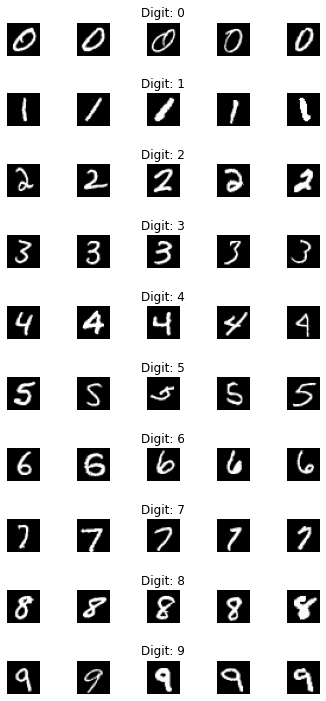

In [2]:
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
num_of_samples_train=[]
num_of_samples_test=[]
cols = 5
num_classes = 10
 
fig, axs = pyplot.subplots(nrows=num_classes, ncols=cols, figsize=(5,10))
fig.tight_layout()
 
for i in range(cols):
    for j in range(num_classes):
      x_selected_train = trainX[trainy == j]
      x_selected_test = testX[testy == j]
      
      # plot raw pixel data
      axs[j][i].imshow(x_selected_train[random.randint(0,(len(x_selected_train) - 1)), :, :], cmap=pyplot.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title("Digit: " + str(j))
        num_of_samples_train.append(len(x_selected_train))
        num_of_samples_test.append(len(x_selected_test))

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


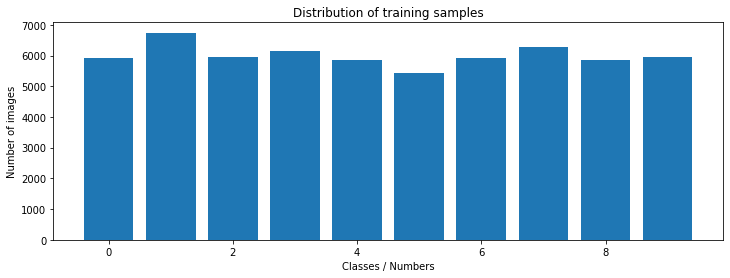

In [3]:
print(num_of_samples_train)
pyplot.figure(figsize=(12, 4))
pyplot.bar(range(0, num_classes), num_of_samples_train)
pyplot.title("Distribution of training samples")
pyplot.xlabel("Classes / Numbers")
pyplot.ylabel("Number of images")
pyplot.show()

[980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]


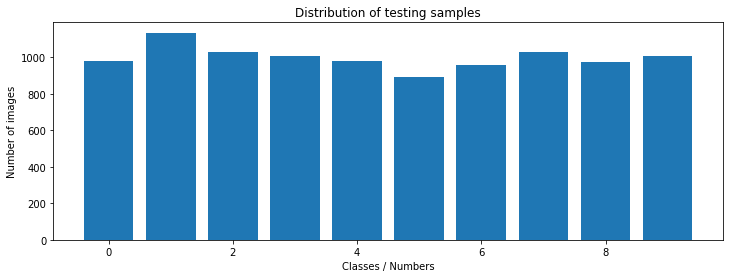

In [4]:
print(num_of_samples_test)
pyplot.figure(figsize=(12, 4))
pyplot.bar(range(0, num_classes), num_of_samples_test)
pyplot.title("Distribution of testing samples")
pyplot.xlabel("Classes / Numbers")
pyplot.ylabel("Number of images")
pyplot.show()

# Carregar conjunto de dados
Sabe-se algumas coisas sobre o conjunto de dados.

Por exemplo, sabe-se que as imagens estão todas pré-alinhadas (por exemplo, cada imagem contém apenas um dígito desenhado à mão), que todas as imagens têm o mesmo tamanho quadrado de 28 × 28 pixels e que as imagens são em tons de cinza.

Portanto, pode-se carregar as imagens e remodelar as matrizes de dados para ter um único canal de cor.

Também sabe-se que existem 10 classes e que as classes são representadas como inteiros únicos.

Pode-se, portanto, usar uma codificação one hot para o elemento de classe de cada amostra, transformando o inteiro em um vetor binário de 10 elementos com 1 para o índice do valor da classe e 0 valores para todas as outras classes. Podemos fazer isso com a função de utilidade to_categorical ().

A função load_dataset () implementa esses comportamentos e pode ser usada para carregar o conjunto de dados.

In [5]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

#Prepare Pixel Data
Os valores de pixel para cada imagem no conjunto de dados são inteiros sem sinal no intervalo entre preto e branco, ou 0 e 255.

Não se sabe a melhor maneira de dimensionar os valores de pixel para modelagem, mas sabe-se que algum dimensionamento será necessário.

Um bom ponto de partida é normalizar os valores de pixel de imagens em tons de cinza, por exemplo, redimensione-os para o intervalo [0,1]. Isso envolve primeiro a conversão do tipo de dados de inteiros sem sinal em flutuantes e, em seguida, a divisão dos valores de pixel pelo valor máximo.

A função load_dataset () implementa esses comportamentos e pode ser usada para carregar o conjunto de dados.

In [6]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# Definição do modelo

O modelo tem dois aspectos principais: o front-end de extração de recursos composto por camadas convolucionais e de pooling e o back-end do classificador que fará uma previsão.

Para o front-end convolucional, pode-se começar com uma única camada convolucional com um tamanho de filtro pequeno (3,3) e um número modesto de filtros (32) seguido por uma camada de pooling máximo. Os mapas de filtro podem então ser nivelados para fornecer recursos ao classificador.

Dado que o problema é uma tarefa de classificação multiclasse, sabemos que precisaremos de uma camada de saída com 10 nós para prever a distribuição de probabilidade de uma imagem pertencente a cada uma das 10 classes. Isso também exigirá o uso de uma função de ativação softmax. Entre o extrator de feições e a camada de saída, podemos adicionar uma camada densa para interpretar as feições, neste caso com 100 nós.

Todas as camadas usarão a função de ativação ReLU e o esquema de  inicializador de escala de variância uniforme, ambas as práticas recomendadas.

Usaremos uma configuração conservadora para o otimizador de descida gradiente estocástico com uma taxa de aprendizado de 0,01 e um momentum de 0,9. A função de perda de entropia cruzada categórica será otimizada, adequada para classificação multiclasse, e monitoraremos a métrica de precisão da classificação, que é apropriada dado que temos o mesmo número de exemplos em cada uma das 10 classes.



In [7]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	print(model.summary())
	return model

# Avaliar o modelo

O modelo será avaliado por meio de validação cruzada quíntupla. O valor de k = 5 foi escolhido para fornecer uma linha de base para avaliações repetidas e não ser tão grande a ponto de exigir um longo tempo de execução. Cada conjunto de teste terá 20% do conjunto de dados de treinamento, ou cerca de 12.000 exemplos, próximo ao tamanho do conjunto de teste real para este problema.

O conjunto de dados de treinamento é embaralhado antes de ser dividido, e o embaralhamento da amostra é executado a cada vez, de modo que qualquer modelo que avaliarmos terá o mesmo trem e conjuntos de dados de teste em cada dobra, fornecendo uma comparação entre os modelos.

Será treinado o modelo de linha de base para modestas 10 épocas de treinamento com um tamanho de lote padrão de 32 exemplos. O conjunto de testes para cada dobra será utilizado para avaliar o modelo tanto durante cada época da corrida de treinamento, para posteriormente criar curvas de aprendizado, quanto no final da corrida, para  estimar o desempenho do modelo. Como tal, acompanhar o histórico resultante de cada corrida, bem como a precisão da classificação da dobra.

A função evaluate_model () abaixo implementa esses comportamentos, tomando o conjunto de dados de treinamento como argumentos e retornando uma lista de pontuações de precisão e históricos de treinamento que podem ser resumidos posteriormente.

In [8]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	models, scores, histories = list(), list() , list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# models stores scores
		models.append(model)
		scores.append(acc)
		histories.append(history)
	return models, scores, histories

#Resultados
Uma vez avaliado o modelo, pode-se apresentar os resultados.

Há dois aspectos principais a apresentar: o diagnóstico do comportamento de aprendizagem do modelo durante o treinamento e a estimativa do desempenho do modelo. Eles podem ser implementados usando funções separadas.

Primeiro, o diagnóstico envolve a criação de um gráfico de linha mostrando o desempenho do modelo no treinamento e o conjunto de teste durante cada dobra da validação cruzada k-fold. Esses gráficos são valiosos para se ter uma ideia se um modelo está com overfitting, underfitting ou tem um bom ajuste para o conjunto de dados.

Criar-se uma única figura com dois subplots, um para perda e outro para precisão. As linhas azuis indicam o desempenho do modelo no conjunto de dados de treinamento e as linhas laranja indicam o desempenho no conjunto de dados de teste de sustentação. A função sumarizar_diagnostics () abaixo cria e mostra este gráfico dados os históricos de treinamento coletados.

In [9]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):

	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		pyplot.legend(['loss', 'val_loss'])
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
		pyplot.legend(['accuracy', 'val_accuracy'])
		pyplot.tight_layout(pad=3.0)
	pyplot.show()
 


Em seguida, as pontuações de precisão da classificação coletadas durante cada dobra podem ser resumidas calculando a média e o desvio padrão. Isso fornece uma estimativa do desempenho médio esperado do modelo treinado neste conjunto de dados, com uma estimativa da variância média na média. Também resumiremos a distribuição das pontuações criando e mostrando um diagrama de caixa.

A função summarize_performance () abaixo implementa isso para uma determinada lista de pontuações coletadas durante a avaliação do modelo.

In [10]:
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

In [11]:
	#main 
  # load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	models, scores, histories = evaluate_model(trainX, trainY)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________
None
> 98.583
Model: "sequential_1"
_________________________________________________________________
Layer (type)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


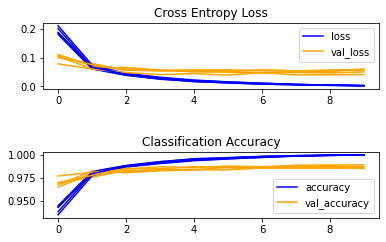

In [12]:
	# learning curves
	summarize_diagnostics(histories)

Accuracy: mean=98.647 std=0.140, n=5


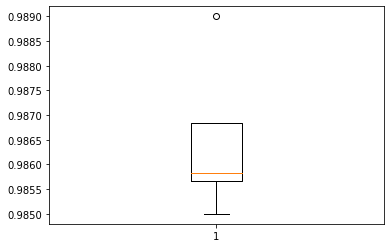

In [13]:
	# summarize estimated performance
	summarize_performance(scores)

In [14]:
def predict_from_url(url,model):
  response = requests.get(url, stream=True)
  img = Image.open(response.raw)
  img_array = asarray(img)
  resized = cv2.resize(img_array, (28,28))
  gray_scale = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
  image = cv2.bitwise_not(gray_scale)
  image = image/255
  image = image.reshape(1,28,28,1)
  prediction  = argmax(model.predict(image), axis=-1)
  return str(prediction)

In [15]:
for n in range(1,10):
  url = 'https://raw.githubusercontent.com/HemersonRafael/ml/main/CNN/' + str(n) + '.jpg'
  print("Real digit: ", n ,"Predicted digit: ", predict_from_url(url,models[0]))

Real digit:  1 Predicted digit:  [5]
Real digit:  2 Predicted digit:  [2]
Real digit:  3 Predicted digit:  [3]
Real digit:  4 Predicted digit:  [4]
Real digit:  5 Predicted digit:  [3]
Real digit:  6 Predicted digit:  [6]
Real digit:  7 Predicted digit:  [2]
Real digit:  8 Predicted digit:  [8]
Real digit:  9 Predicted digit:  [3]
